In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
#Upload Data From CSV to dataframe
data = pd.read_csv("data2.csv")

In [3]:
#Remove columns with missing values more than threshold
threshold = 0.2
missing_percentage = data.isnull().sum() / len(data)
filtered_data = data.loc[:, missing_percentage <= threshold]

In [4]:
#Seperate categorical and numerical columns
categorical_cols = filtered_data.select_dtypes(include=['object']).columns
numerical_cols = filtered_data.select_dtypes(exclude=['object']).columns

In [5]:
#Label Encoding for categorical columns and impute missing values for numerical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
    label_encoders[col] = le

imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data_numerical = pd.DataFrame(imputer.fit_transform(filtered_data[numerical_cols]), columns=numerical_cols)

imputed_data = pd.concat([imputed_data_numerical, filtered_data[categorical_cols]], axis=1)


C:\Users\eric9\AppData\Local\Temp\ipykernel_34888\872345375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
C:\Users\eric9\AppData\Local\Temp\ipykernel_34888\872345375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))


In [6]:
X = imputed_data.drop('AKI', axis=1)
y = imputed_data['AKI']

In [7]:
# Lasso Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Assuming `X` is your feature matrix and `y` is your target variable
lasso = Lasso(alpha=0.01, random_state=42)  # Adjust alpha as needed
lasso.fit(X, y)

# Use SelectFromModel to select important features
model = SelectFromModel(lasso, prefit=True)
X_selected = model.transform(X)

# Get the selected feature names
selected_features = X.columns[(model.get_support())]
print("Selected Features:", selected_features)

Selected Features: Index(['los_hospital', 'anchor_age', 'glucose_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'hematocrit_max', 'wbc_max', 'bicarbonate_max', 'bun_max',
       'calcium_max', 'chloride_max', 'creatinine_max', 'glucose_max',
       'sodium_max', 'pt_max', 'ptt_max', 'alt_max', 'bilirubin_total_max',
       'admission_type', 'insurance'],
      dtype='object')


C:\Users\eric9\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [8]:
# Identify the target variable and scale the values
X = X[selected_features]  
y = imputed_data['AKI']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [10]:
#  Train the model
gb_model_tuned = GradientBoostingClassifier(
    n_estimators=50,      
    learning_rate=0.1,    
    max_depth=3,          
    min_samples_leaf=10,  
    random_state=42
)

In [11]:
# Fit the model
gb_model_tuned.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=10, n_estimators=50,
                           random_state=42)

In [12]:
# Predict the target variable
y_pred_prob_gb = gb_model_tuned.predict_proba(X_test)[:, 1]
y_pred_gb = (y_pred_prob_gb > 0.5).astype(int)

In [13]:
# Calculate the AUC score
auc_gb = roc_auc_score(y_test, y_pred_prob_gb)
print(f"Gradient Boosting AUC Score: {auc_gb}")
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

Gradient Boosting AUC Score: 0.8639572303539914
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.64        78
         1.0       0.88      0.91      0.89       247

    accuracy                           0.84       325
   macro avg       0.78      0.76      0.77       325
weighted avg       0.83      0.84      0.83       325

Gradient Boosting Confusion Matrix:
[[ 48  30]
 [ 23 224]]


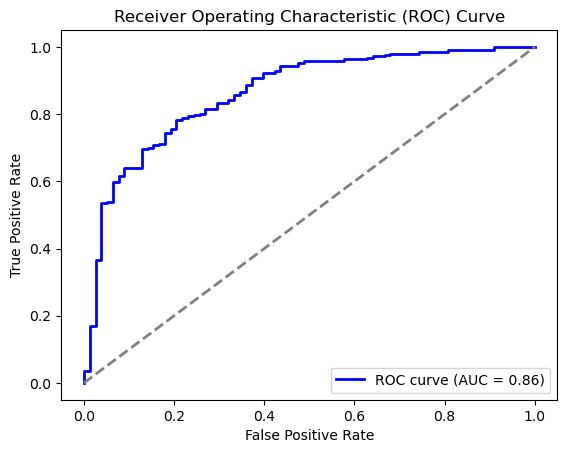

In [14]:
#   Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gb)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_gb))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()